# Can we use the Federal Prime Lending Rate to predict Mutual Fund Performance?

In [15]:
import yfinance as yf
import pandas as pd
import requests
import pickle
from bs4 import BeautifulSoup
import numpy as np
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts

import warnings 


%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Yahoo Finance Data on the XLV Fund

In [16]:
xlv = yf.Ticker('XLV')
xlv_hist = xlv.history(period = 'max', actions = False)
xlv_hist['Change'] = xlv_hist['Close'] - xlv_hist['Open']
xlv_hist['Volume'] = xlv_hist.Volume.astype('float64')
xlv_hist.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-12-22,18.41,18.60,18.41,18.58,5700.0,0.17
1998-12-23,18.69,18.99,18.69,18.99,18100.0,0.30
1998-12-24,19.02,19.11,18.94,19.11,4900.0,0.09
1998-12-28,19.05,19.11,18.83,18.83,15500.0,-0.22
1998-12-29,18.83,19.25,18.83,19.25,5300.0,0.42


In [17]:

xlv_hist_monthly = xlv_hist['Close'].resample('MS')
xlv_monthly_mean = pd.DataFrame(xlv_hist_monthly.mean())

xlv_monthly_mean.reindex(index=xlv_monthly_mean.index[::-1])

,Close
Date,
2020-01-01,102.156250
2019-12-01,100.354762
2019-11-01,95.596500
2019-10-01,90.148696
2019-09-01,89.694500
...,...
1999-04-01,21.752857
1999-03-01,20.773913
1999-02-01,20.173684


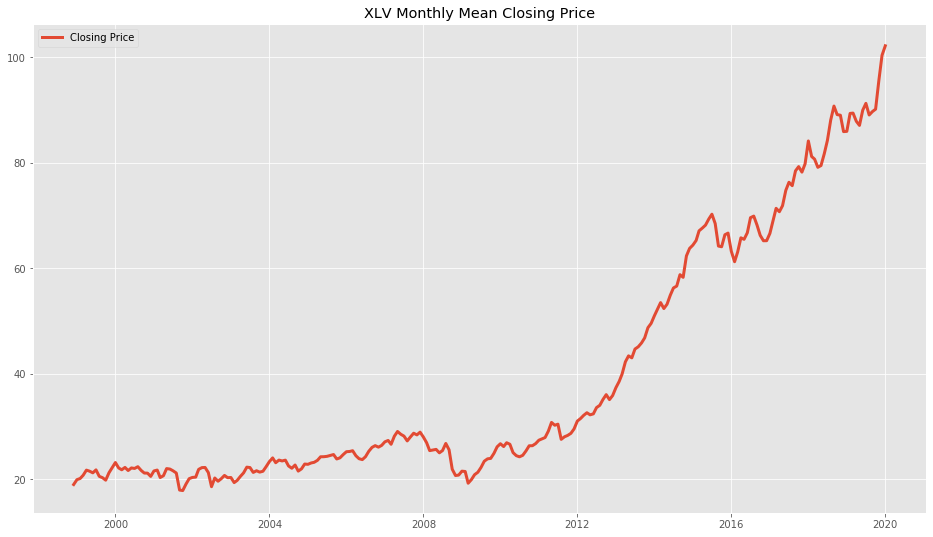

<Figure size 432x288 with 0 Axes>

In [18]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
fig = plt.figure(figsize = (16,9))
plt.plot(xlv_monthly_mean, linewidth = 3, label = 'Closing Price')
plt.title('XLV Monthly Mean Closing Price')
plt.legend()
plt.show();
plt.savefig('XLV_beginning_close_price')

#There is an upwards Trend

## Perform a Seasonal Decomposition to check for trends, seasonality, and residual distribution

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(xlv_monthly_mean))

In [20]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

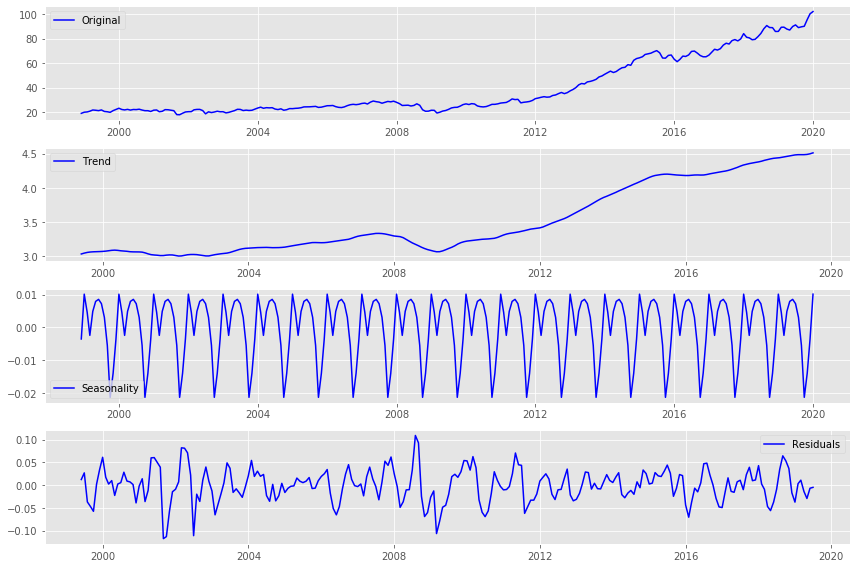

In [21]:
# Original Monthly Mean 
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(xlv_monthly_mean, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [22]:
#check stationarity
def stationarity_check(TS):
    
    from statsmodels.tsa.stattools import adfuller
    rolmean = TS.rolling(window = 12, center = False).mean()
    rolstd = TS.rolling(window = 12, center = False).std()
    
    dftest = adfuller(TS)
    
    fig = plt.figure(figsize = (16,9))
    orig = plt.plot(TS, color = 'b', label = 'original')
    mean = plt.plot(rolmean, color = 'r', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    print('Results of Dickey-Fuller Test')
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
    return None

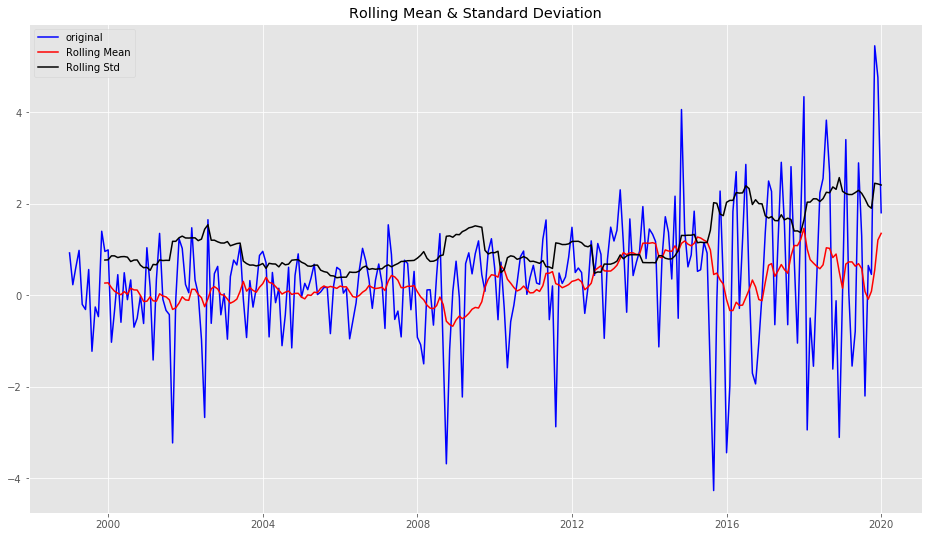

Results of Dickey-Fuller Test
Test Statistic                -1.131819e+01
p-value                        1.192110e-20
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [23]:
#best (first order)
xlv_differenced_mean = xlv_monthly_mean.diff(periods = 1).dropna()
stationarity_check(xlv_differenced_mean.Close)

#### P-val = 7.32e-11 -->  Reject the null hypothesis that the data is not stationary

## ARMA: Auto-Regressive - PACF

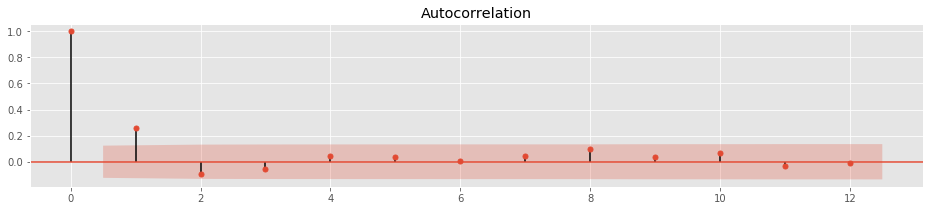

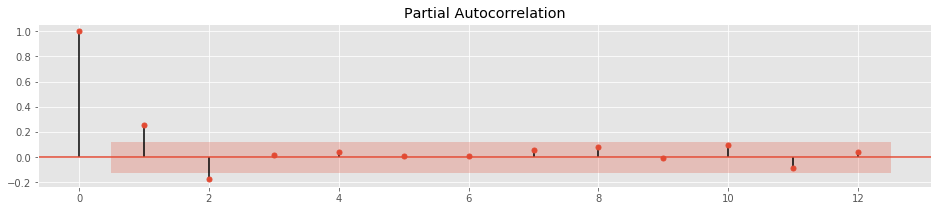

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (16,3))
plot_acf(xlv_differenced_mean, ax = ax, lags = 12);

fig, ax = plt.subplots(figsize = (16,3))
plot_pacf(xlv_differenced_mean, ax=ax, lags = 12);

In [25]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,2), seasonal_order=(1,1,2,12));
res = mod.fit();
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -408.854
Date:                            Mon, 13 Jan 2020   AIC                            831.708
Time:                                    20:02:01   BIC                            856.102
Sample:                                12-01-1998   HQIC                           841.536
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2920      0.569      0.513      0.608      -0.824       1.408
ma.L1          0.0091      0.569      0.016      0.987      -1.106       1.124
ma.L2         -0.1916      0.197     -0.972      0.331      -0.578       0.195
ar.S.L12      -0.9994      0.071    -14.129      0.000      -1.138      -0.861
ma.S.L12       0.1504      0.528      0.285      0.776      -0.885       1.186
ma.S.L24      -0.8325      0.470     -1.770      0.077      -1.754       0.089
sigma2         1.5791      0.729      2.167      0.030       0.151       3.007
===================================================================================
Ljung-Box (Q):                       29.89   Jarque-Bera (JB):                57.78
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -412.120
Date:                            Mon, 13 Jan 2020   AIC                            834.239
Time:                                    20:02:02   BIC                            851.663
Sample:                                12-01-1998   HQIC                           841.259
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1934      0.171     -1.131      0.258      -0.529       0.142
ma.L1          0.5126      0.161      3.193      0.001       0.198       0.827
ar.S.L12      -0.0771      0.074     -1.038      0.299      -0.223       0.068
ma.S.L12      -0.8324      0.062    -13.526      0.000      -0.953      -0.712
sigma2         1.6760      0.126     13.274      0.000       1.429       1.923
===================================================================================
Ljung-Box (Q):                       32.26   Jarque-Bera (JB):                50.63
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.36   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
xlv_monthly_auto = xlv_monthly_mean.copy()

In [28]:
xlv_monthly_mean['Close_P'] = res.predict(start = 225, end = 254, dynamic = False)

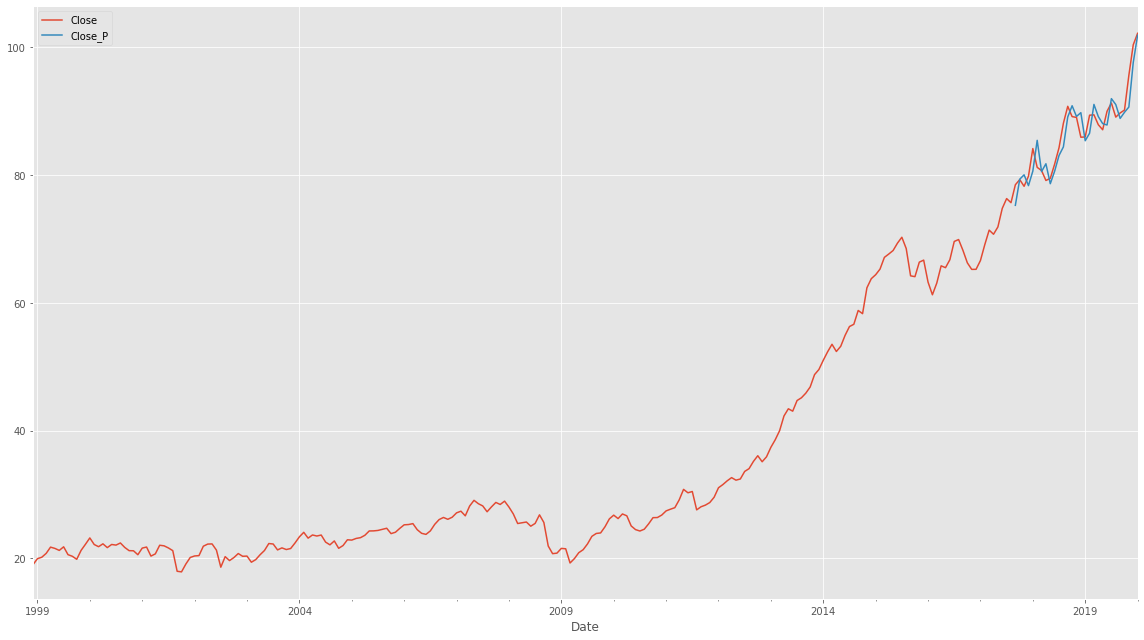

In [29]:
xlv_monthly_mean[['Close', 'Close_P']].plot(figsize = (16,9));
plt.legend(loc = 'upper left')
plt.tight_layout();

In [30]:
xlv_monthly_mean.head()

,Close,Close_P
Date,,
1998-12-01,19.021429,NaN
1999-01-01,19.944737,NaN
1999-02-01,20.173684,NaN
1999-03-01,20.773913,NaN
1999-04-01,21.752857,NaN


In [31]:
from dateutil.relativedelta import relativedelta
import datetime

start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index = date_list, columns = xlv_monthly_mean.columns)
xlv_monthly_mean = pd.concat([xlv_monthly_mean, future])

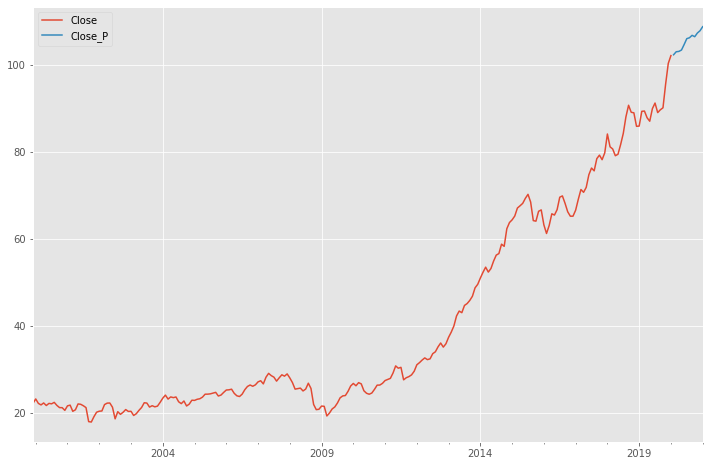

In [32]:
xlv_monthly_mean['Close_P'] = res.predict(start = 254, end = 266, dynamic = True)
xlv_monthly_mean[['Close', 'Close_P']].iloc[-254:].plot(figsize=(12,8))
plt.savefig('XLV_predict_future.png', bbox_inches = 'tight')


### Dynamic Forecasting

In [33]:
prediction = res.get_forecast(steps = 36)
pred_conf = prediction.conf_int()


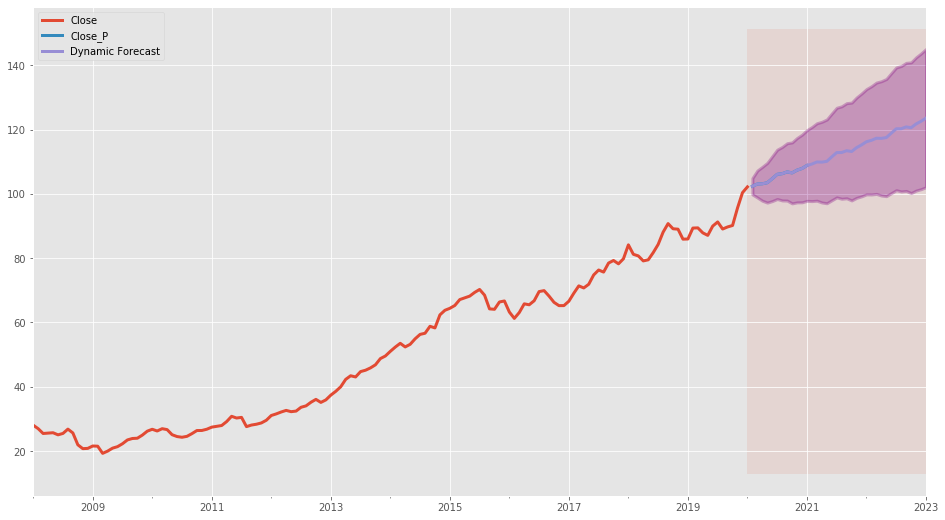

In [34]:
ax = xlv_monthly_mean['2008':].plot(label = 'Observed', figsize = (16,9), linewidth = 3)
prediction.predicted_mean.plot(label = 'Dynamic Forecast', ax=ax, linewidth = 3)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:,0],
                pred_conf.iloc[:,1], color = 'purple', alpha = .3, linewidth = 3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), pd.to_datetime('2023-01-01'), alpha=.1, zorder=-1)

plt.legend(loc = 'upper left')
plt.show()

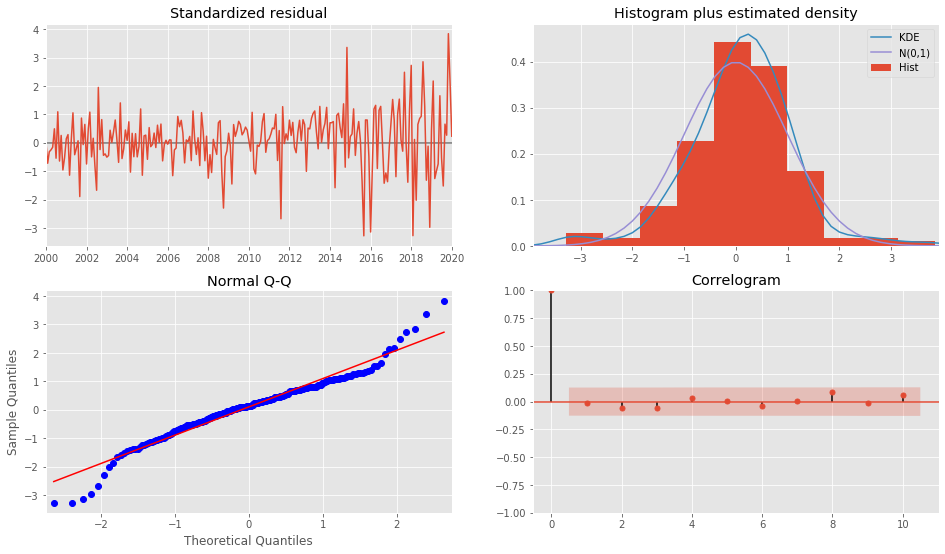

In [35]:
res.plot_diagnostics(figsize = (16,9));

## Auto-ARIMA

In [28]:
# Define the p, d and q parameters to take any value between 0 and 2
import itertools
p = d = q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))
print(pdq)

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
print(pdqs)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [ ]:

warnings.filterwarnings('ignore')
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean.Close, 
                                            order = comb, 
                                            seasonal_order = combs, 
                                            enforce_stationarity = False, 
                                            enforce_invertability = False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {} : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
xlv_monthly_auto['Close_P'] = output_auto.predict(start = 225, end = 254, dynamic = False)
xlv_monthly_auto[['Close', 'Close_P']].plot(figsize = (16,9))
plt.legend(loc = 'upper left')
plt.show()


In [ ]:
xlv_monthly_auto

In [ ]:
from dateutil.relativedelta import relativedelta
import datetime

start_auto = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
date_list_auto = [start_auto + relativedelta(months=x) for x in range(0,12)]
future_auto = pd.DataFrame(index = date_list_auto, columns = xlv_monthly_auto.columns)
xlv_monthly_auto = pd.concat([xlv_monthly_auto, future_auto])

In [ ]:
xlv_monthly_auto['Close_P'] = output_auto.predict(start = 254, end = 266, dynamic = True)
xlv_monthly_auto[['Close', 'Close_P']].iloc[-254:].plot(figsize=(12,8))
plt.legend(loc = 'upper left')
plt.show();



In [ ]:
prediction_auto = output_auto.get_forecast(steps = 36)
pred_conf_auto = prediction_auto.conf_int()
pred_conf_auto

In [ ]:
ax = xlv_monthly_auto['2008':].plot(label = 'Observed', figsize = (16,9), linewidth = 3)
prediction_auto.predicted_mean.plot(label = 'Dynamic Forecast', ax=ax, linewidth = 3)

ax.fill_between(pred_conf_auto.index,
                pred_conf_auto.iloc[:,0],
                pred_conf_auto.iloc[:,1], color = 'purple', alpha = .3, linewidth = 3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), pd.to_datetime('2024-01-01'), alpha=.1, zorder=-1)

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('Auto_ARIMA_Projection.png')
plt.show();
